In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import RectifiedLogistic

plt.rcParams['svg.fonttype'] = 'none'

logger = logging.getLogger(__name__)

TOML_PATH = "/home/vishu/repos/hbmep-paper/configs/rats/J_RCML_000.toml"
DATA_PATH = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/data.csv"
MAT_PATH = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/mat.npy"
RESPONSE = ["APB", "ADM"]
FEATURES = ["participant"]
BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro"

os.makedirs(BUILD_DIR, exist_ok=True)
setup_logging(dir=BUILD_DIR, fname="core")


2024-01-30 14:10:39,791 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/core.log


In [2]:
config = Config(toml_path=TOML_PATH)
config.BUILD_DIR = BUILD_DIR
config.RESPONSE = RESPONSE
config.FEATURES = FEATURES
config.MCMC_PARAMS["num_warmup"] = 10000
config.MCMC_PARAMS["num_samples"] = 10000

df = pd.read_csv(DATA_PATH)
mat = np.load(MAT_PATH)

logger.info(f"df.shape: {df.shape}")
logger.info(f"mat.shape: {mat.shape}")


2024-01-30 14:10:39,883 - __main__ - INFO - df.shape: (50, 4)
2024-01-30 14:10:39,883 - __main__ - INFO - mat.shape: (50, 428, 2)


In [3]:
model = RectifiedLogistic(config=config)
df, encoder_dict = model.load(df=df)

model.plot(df=df, encoder_dict=encoder_dict)
mcmc, posterior_samples = model.run_inference(df=df)

prediction_df = model.make_prediction_dataset(df=df, num=5000)
# prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2024-01-30 14:10:40,084 - hbmep.model.baseline - INFO - Initialized rectified_logistic
2024-01-30 14:10:40,085 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/01_Intro
2024-01-30 14:10:40,086 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro
2024-01-30 14:10:40,090 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2024-01-30 14:10:40,091 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-30 14:10:40,092 - hbmep.dataset.core - INFO - Processing data ...
2024-01-30 14:10:40,094 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-01-30 14:10:40,094 - hbmep.model.baseline - INFO - Rendering ...
2024-01-30 14:10:40,221 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/dataset.pdf
2024-01-30 14:10:40,222 - hbmep.utils.utils - INFO - func:plot took: 0.13 sec
2024-01-30 14:10:40,222 - hbmep.mod

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

2024-01-30 14:12:05,536 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 25.31 sec
2024-01-30 14:12:05,550 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2024-01-30 14:14:30,904 - hbmep.utils.utils - INFO - func:predict took: 2 min and 25.35 sec
2024-01-30 14:14:30,905 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2024-01-30 14:14:35,497 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/recruitment_curves.pdf
2024-01-30 14:14:35,502 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.60 sec
2024-01-30 14:14:35,503 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2024-01-30 14:15:43,968 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/posterior_predictive_check.pdf
2024-01-30 14:15:43,979 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 1 min and 8.48 sec
2024-01-30 14:15:43,979

In [4]:
obs = posterior_predictive[site.obs]
obs.shape

(40000, 5000, 2)

<Axes: xlabel='pulse_amplitude', ylabel='APB'>

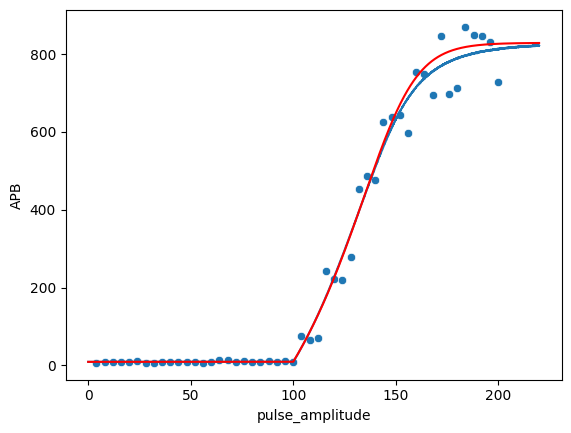

In [5]:
sites = [site.a, site.b, site.v, site.L, site.ell, site.H]
params_mode = [stats.mode(posterior_samples[u], axis=0) for u in sites]
params_mode = [param.mode for param in params_mode]
params_mode = [param[0] for param in params_mode]
params = [np.mean(posterior_samples[u], axis=0) for u in sites]
params = [param[0] for param in params]

x = prediction_df[model.intensity].values

sns.scatterplot(x=df[model.intensity], y=1000 * df[model.response[0]])
sns.lineplot(x=x, y=1000 * obs.mean(axis=0)[:, 0])
sns.lineplot(x=x, y=1000 * F.rectified_logistic(x, *(param[0] for param in params)), color="red")


In [ ]:
# l4 = Logistic4(config=config)
# df, encoder_dict = l4.load(df=df)
# mcmc_l4, posterior_samples_l4 = l4.run_inference(df=df)
# posterior_predictive_l4 = l4.predict(df=prediction_df, posterior_samples=posterior_samples_l4)
# # dest = os.path.join(model.build_dir, "l4_recruitment_curve.pdf")
# # l4.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples_l4, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l4, destination_path=dest)
# # dest = os.path.join(model.build_dir, "l4_ppd.pdf")
# # l4.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive_l4, destination_path=dest)


2024-01-25 10:17:01,125 - hbmep.model.baseline - INFO - Initialized logistic4
2024-01-25 10:17:01,126 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/01_Intro
2024-01-25 10:17:01,126 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro
2024-01-25 10:17:01,127 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2024-01-25 10:17:01,127 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-25 10:17:01,127 - hbmep.dataset.core - INFO - Processing data ...
2024-01-25 10:17:01,128 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2024-01-25 10:17:01,129 - hbmep.model.baseline - INFO - Running inference with logistic4 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2024-01-25 10:17:11,439 - hbmep.utils.utils - INFO - func:run_inference took: 10.31 sec
2024-01-25 10:18:07,038 - hbmep.utils.utils - INFO - func:predict took: 55.60 sec


In [6]:
a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])

colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]
time_const = 1000


In [7]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)
obs = posterior_predictive[site.obs] * time_const
obs_hpdi = hpdi(obs, prob=.95)

obs_map = obs.mean(axis=0)

H = posterior_samples[site.H]


In [64]:
features, intensity,= model._collect_regressor(df=prediction_df)
features, n_features = features
intensity, n_data = intensity
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (1, model.n_response))

feature0 = features[0].reshape(-1,)

a, b, v, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.v], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

params = [a, b, v, L, ell, H]
params = [u[:, feature0] for u in params]

fn_out = F.rectified_logistic(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = F.prime(F.rectified_logistic, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out = np.array(fn_prime_out) * time_const
fn_prime_out.shape


(40000, 5000, 2)

2024-01-30 17:00:09,173 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/01c_HB.png


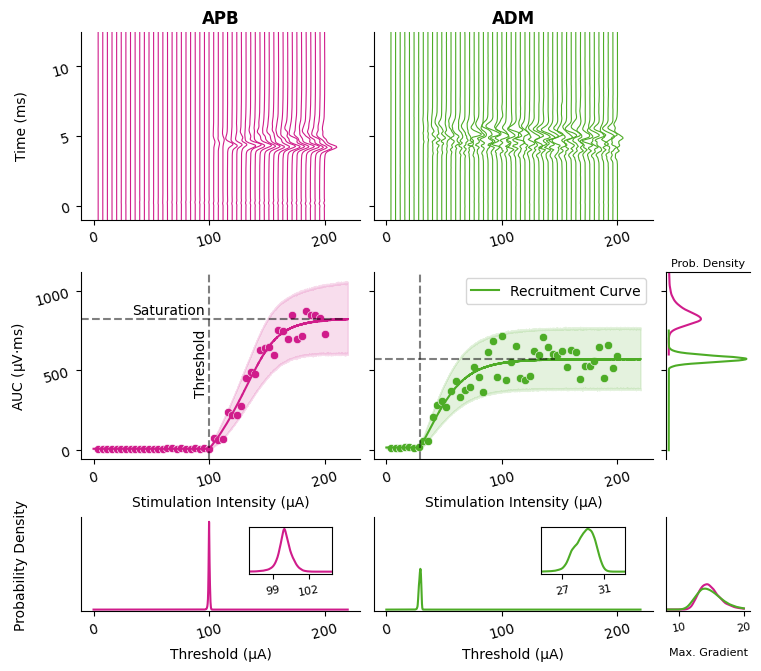

In [98]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], label="Recruitment Curve")
    # sns.lineplot(x=x_pred, y=1000 * F.rectified_logistic(x_pred, *(param[muscle_ind] for param in params)), ax=ax, color=colors[muscle_ind], label="Recruitment Curve")

    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )

    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.95, alpha=.5, linestyle="--")
        ax.text(a_map[0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    if ax == axes[1, 1]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--")
        # ax.text(a_map[0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 1]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")
        # ax.text(a_map[0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ## Debuging
    # axes[1, 1].axhline(obs_map.max(axis=0)[muscle_ind])
    # axes[1, 2].axhline(obs_map.max(axis=0)[muscle_ind])

    ax = axes[2, muscle_ind]
    samples = a[:, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    if muscle_ind == 0:
        samples = (H[:, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(0, 20, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


##############
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])
axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")

axes[1, 1].legend(loc="upper right")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)


axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8)
# axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(model.build_dir, "01c_HB.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01c_HB.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")

In [ ]:
import pickle


src = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/minimize_result.pkl"
with open(src, "rb") as f:
    minimize_results, = pickle.load(f)


In [102]:
x_pred.shape

(5000,)

In [115]:
import jax
jax.grad(F.logistic4)(minimize_results[0].x[0], *minimize_results[0].x) * 1000

Array(16.7099479, dtype=float64)

In [103]:
F.prime(F.logistic4, x_pred, *minimize_results[0].x)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

2024-01-30 17:15:25,992 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/01b_Nelder_Mead.png


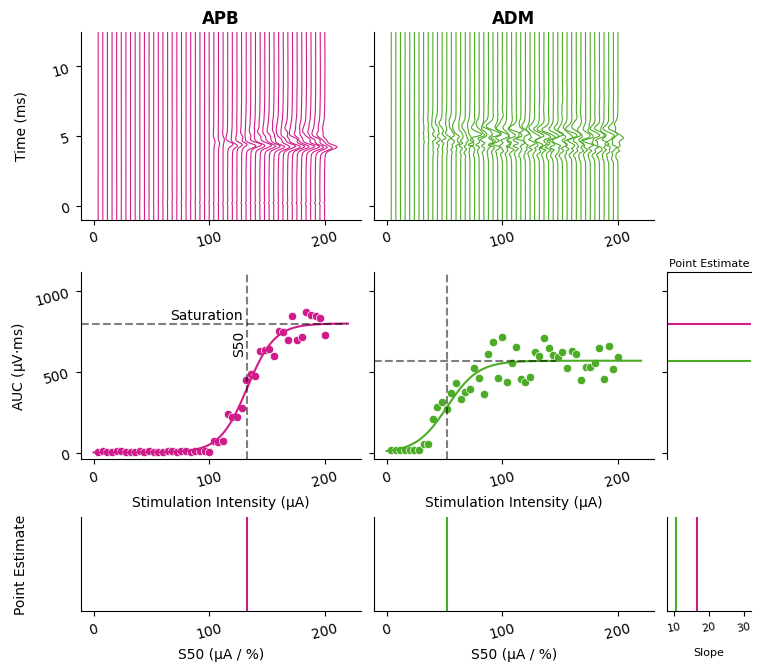

In [119]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    sns.lineplot(x=x_pred, y=1000 * F.logistic4(x_pred, *minimize_results[muscle_ind].x), ax=ax, color=colors[muscle_ind])

    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], ax=ax)

    if ax == axes[1, 0]:
        ax.axvline(x=minimize_results[muscle_ind].x[0], color="black", alpha=.5, linestyle="--")
        ax.text(minimize_results[muscle_ind].x[0] - 1, minimize_results[muscle_ind].x[-1] * 1000 - 40, "S50", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=minimize_results[muscle_ind].x[-1] * 1000, xmax=.95, color="black", alpha=.5, linestyle="--")
        ax.text(minimize_results[muscle_ind].x[0] - 35, minimize_results[muscle_ind].x[-1] * 1000 + 10, "Saturation", va="bottom", ha="center")

    if ax == axes[1, 1]:
        ax.axvline(x=minimize_results[muscle_ind].x[0], color="black", alpha=.5, linestyle="--")
        # ax.text(minimize_results[muscle_ind].x[0] - 1, minimize_results[muscle_ind].x[-1] * 1000 - 40, "S50", rotation=90, va="top", ha="right")

    if ax == axes[1, 1]:
        ax.axhline(y=minimize_results[muscle_ind].x[-1] * 1000, xmax=.65, color="black", alpha=.5, linestyle="--")
        # ax.text(minimize_results[muscle_ind].x[0] - 35, minimize_results[muscle_ind].x[-1] * 1000 + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    ax.axvline(x=minimize_results[muscle_ind].x[0], color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")

    ax = axes[1, 2]
    ax.axhline(y=minimize_results[muscle_ind].x[-1] * 1000, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad_point = jax.grad(F.logistic4)(minimize_results[muscle_ind].x[0], *minimize_results[muscle_ind].x) * 1000
    ax.axvline(x=max_grad_point, color=colors[muscle_ind])


for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )



##############
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])
axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])

if axes[1, 1].get_legend():
    axes[1, 1].get_legend().set_visible(False)

if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].set_ylabel("Point Estimate")

axes[2, 0].set_xlabel("S50 (µA / %)", size=axis_label_size)
axes[2, 1].set_xlabel("S50 (µA / %)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Slope", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Point Estimate", size=8)
axes[1, 2].sharey(axes[1, 0])
axes[1, 2].xaxis.set_label_position('top')
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(model.build_dir, "01b_Nelder_Mead.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01b_Nelder_Mead.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")


In [117]:
minimize_results[0].x

array([1.32822056e+02, 8.39082179e-02, 2.41897147e-03, 7.96582186e-01])

In [118]:
minimize_results[1].x

array([5.23729277e+01, 7.48712243e-02, 1.00000000e-09, 5.68972607e-01])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

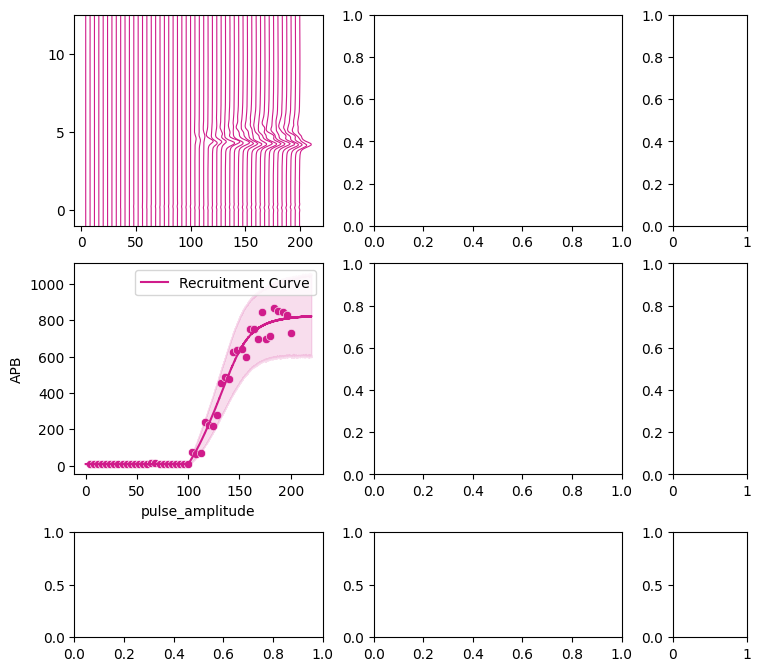

In [10]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    # max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    # samples = max_grad
    # kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(8, 30, 1000)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "01b.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01b.png")
fig.savefig(dest, dpi=600)


In [ ]:
a_l4, b_l4, L_l4, H_l4 = \
    posterior_samples_l4[site.a], \
    posterior_samples_l4[site.b], \
    posterior_samples_l4[site.L], \
    posterior_samples_l4[site.H]

params = [a_l4, b_l4, L_l4, H_l4]
params = [u[:, feature0, feature1] for u in params]

fn_out_l4 = F.logistic4(intensity, *tuple(params))
fn_out_l4 = np.array(fn_out_l4)

fn_prime_out_l4 = F.prime(F.logistic4, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out_l4 = np.array(fn_prime_out_l4) * time_const
fn_prime_out_l4.shape


(16000, 5000, 2)

<Axes: xlabel='pulse_amplitude', ylabel='Biceps'>

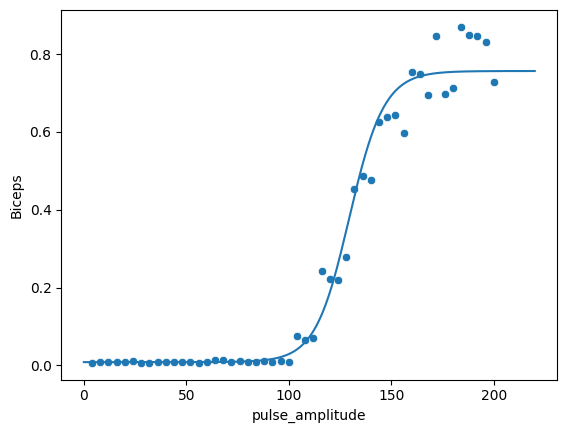

In [ ]:
sns.scatterplot(x=df["pulse_amplitude"], y=df[model.response[0]])
sns.lineplot(x=prediction_df["pulse_amplitude"], y=fn_out_l4[..., 0].mean(axis=0))


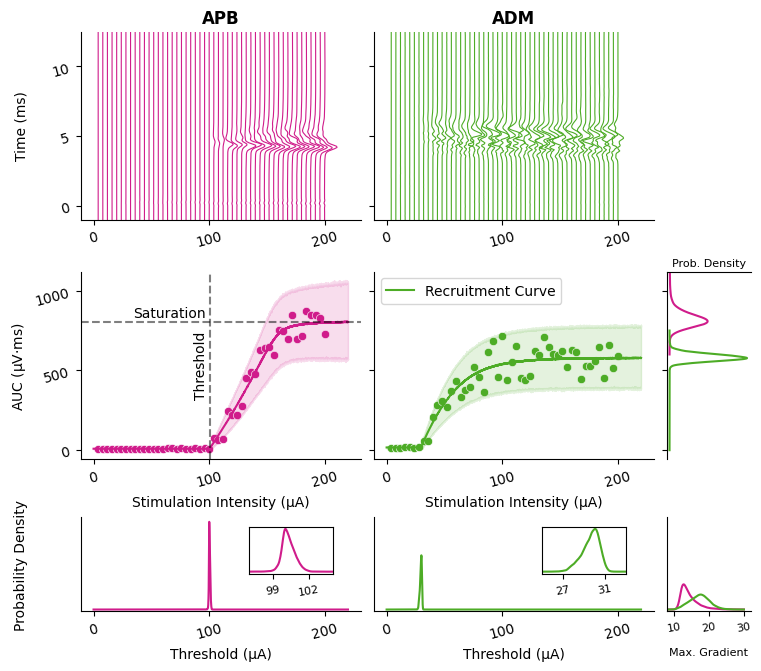

In [ ]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.6510, 0.3804, 0.1020), (0.2055, 0., 0.4000)]
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(8, 30, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "01b.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01b.png")
fig.savefig(dest, dpi=600)


In [ ]:
l4_prime.max(axis=0)

array([102.9116699 ,   8.03259215])

<Axes: xlabel='pulse_amplitude'>

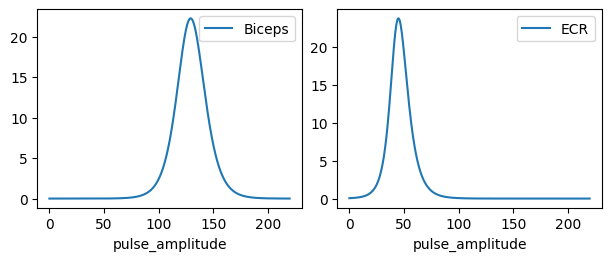

In [ ]:
l4_prime = fn_prime_out_l4.mean(axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5), constrained_layout=True, squeeze=False)
ax = axes[0, 0]
sns.lineplot(x=prediction_df[model.intensity], y=l4_prime[:, 0], label=f"{model.response[0]}", ax=ax)
# ax.axvline(l4_prime[:, 0].mean())
ax = axes[0, 1]
sns.lineplot(x=prediction_df[model.intensity], y=l4_prime[:, 1], label=f"{model.response[1]}", ax=ax)


In [ ]:
l4_prime.max(axis=0)

array([22.27379549, 23.71091663])

In [ ]:
obs_l5 = np.array(posterior_predictive_l5[site.obs]) * time_const
obs_l4 = np.array(posterior_predictive_l4[site.obs]) * time_const
obs_relu = np.array(posterior_predictive_relu[site.obs]) * time_const


In [ ]:
a_l4 = posterior_samples_l4[site.a]
a_l4.shape

(16000, 1, 1, 2)

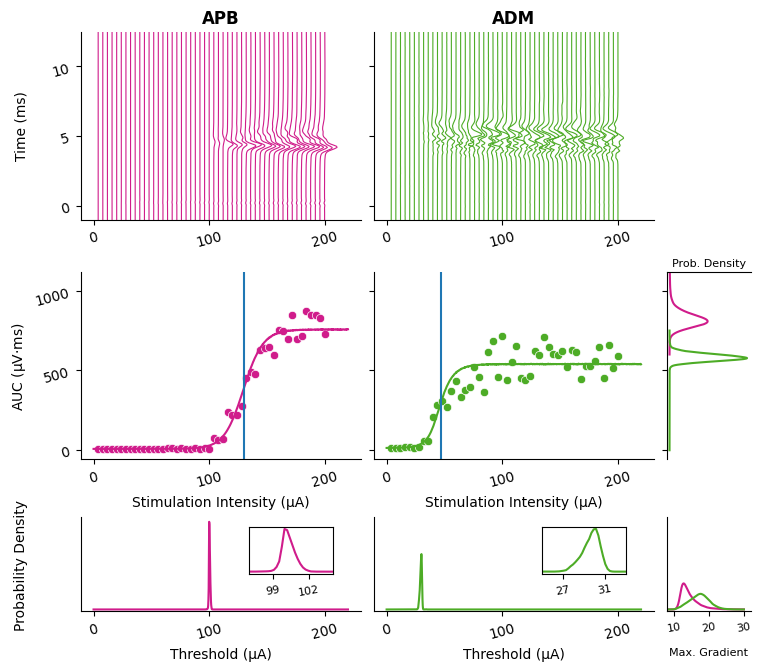

In [ ]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.6510, 0.3804, 0.1020), (0.2055, 0., 0.4000)]
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    # sns.lineplot(x=prediction_df[model.intensity], y=obs_l5.mean(axis=0)[..., muscle_ind], ax=ax, color="grey", alpha=1)
    sns.lineplot(x=prediction_df[model.intensity], y=obs_l4.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1)
    ax.axvline(a_l4[:, 0, 0, muscle_ind].mean())
    # sns.lineplot(x=prediction_df[model.intensity], y=obs_relu.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1)
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(8, 30, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "01a.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01a.png")
fig.savefig(dest, dpi=600)
